# パラメータ化された量子回路の学習

この節では量子回路に基づいたモデルをどのように学習させていくかを勾配を用いた手法を用いてより詳細に紹介します。学習モデルの制約とその克服の方法について学んでいきます。

## イントロダクション

Like classical models, we can train parameterized quantum circuit models to perform data-driven tasks. The task of learning an arbitrary function from data is mathematically expressed as the minimization of a [cost](gloss:cost) or loss function $f(\class{theta_vec}{\vec\theta})$, also known as the
objective function, with respect to the parameter vector $\class{theta_vec}{\vec\theta}$. Generally, when training a parameterized quantum circuit model, the function we are trying to minimise is the [expectation value](gloss:expectation-value): $\class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat{H}}\class{ket_psi_theta}{| \Psi(\vec\theta) \rangle}$

![Image showing a cycle between 'update parameters (theta)' and 'compute (expectation value of H with state Phi(theta))'. The value of the computation is fed back to the 'update parameters' step.](images/training/training.svg)

There are many different types of algorithms that we can use to optimise the parameters of a variational circuit, $\class{u_theta}{\mathbf{U_\theta}}$, (gradient-based, evolutionary, and gradient-free methods). In this course, we will be discussing gradient-based methods. 

## Gradients

If we have a function $f(\class{theta_vec}{\vec\theta})$, and we have access to the gradient of the function, $\vec{\nabla} f(\vec\theta)$, starting from an initial point, then the simplest way to minimize the function is to update the parameters towards the direction of steepest descent of the function: $\vec\theta_{n+1} = \vec\theta_n - \class{eta}{\eta}\class{del}{\vec{\nabla}} f(\class{theta_vec}{\vec\theta})$, where $\eta$ is the learning rate - a small, positive [hyperparameter](gloss:hyperparameter) controlling the size of the update. We continue doing this until we converge to a [local minimum](gloss:local-minimum) of the function, $f(\class{theta_vec_star}{\vec\theta^*})$.

![graph of f(theta) against theta, multiple dots show different states of a gradient descent algorithm finding the minimum of a curve.](images/training/gradient-descent.svg)

This technique is called _gradient descent_ or _[vanilla](gloss:vanilla) gradient descent_, since it's the plain gradient, we aren't doing anything special to it. 

Qiskit provides different methods to compute gradients of expectation values, let's explore them!

First, we need to define our parameterized state, $\class{ket_psi_theta}{|\Psi(\vec\theta)\rangle} = \class{u_theta}{U(\vec\theta)}|00\dots 0\rangle$. In this page, $\class{u_theta}{U(\vec\theta)}$ is the Qiskit [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit on two qubits:

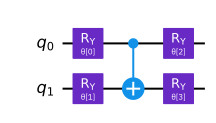

In [1]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

Next we need to define a [Hamiltonian](gloss:hamiltonian), let's use: $\class{h_hat}{\hat H} = \class{z_hat}{\hat Z} \class{kronecker_product}{\bigotimes} \class{z_hat}{\hat Z}$

In [2]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

Putting them together to make the expectation value: $\class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat{H}} \class{ket_psi_theta}{| \Psi(\vec\theta) \rangle}$

In [3]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we write a function to simulate the measurement of the expectation value:

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

To make things concrete, let's fix a point $\vec p$ and an index $i$ and ask: What's the [derivative](gloss:derivative) of the expectation value with respect to parameter $\theta_i$ at point $\vec p$?

$$
    \class{partial_derivative}{\frac{\partial}{\partial \theta_i}} \class{_bra_psi_theta}{\langle \Psi(\vec\theta) |} \class{h_hat}{\hat H} \class{ket_psi_theta}{| \Psi(\vec\theta) \rangle} \class{evaluate}{\bigg\vert_{\vec\theta = \vec p}}
$$

We'll choose a random point $\vec p$ and index $i=2$ (remember we start counting from 0).

In [5]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

### Finite difference gradients

Arguably the simplest way to approximate gradients is with a finite difference scheme. This works independently of the function's inner, possibly very complex, structure.

![graph shows a curve, and dots at three points on the curve. The dots are equally-spaced along the x-axis by eplison.](images/training/finite-difference.svg)

If we are interested in estimating the gradient at $f(\vec \theta)$, we can choose some small distance $\epsilon$ and calculate $f(\vec \theta+\epsilon)$ and $f(\vec \theta-\epsilon)$ and take the difference between the two function values, divided by the distance: $\vec{\nabla} f(\vec \theta) \approx \frac{1}{2\epsilon}\left(f(\vec \theta+\epsilon) - f(\vec \theta-\epsilon) \right)$.

In [6]:
eps = 0.2
# make identity vector with a 1 at index ``index``, otherwise 0
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

0.0225830078125


Instead of doing this manually, we can use Qiskit's [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html) class for this.

In [7]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.0213623046875

Finite difference gradients can be volatile on noisy functions and using the exact formula for the gradient can be more stable. This can be seen above, as although these two calculations make use of the same formula, they yield different results due to the shot noise. In the example image below, we can see the "Noisy finite difference gradient" actually points in the opposite direction of the true gradient!

![Image showing a noisy function, the true (average) gradient of the function, and the incorrectly calculated gradient from the finite difference method](images/training/noisy-gradient.svg)

### Analytic gradients

Analytics gradients evaluate the analytic formula for the gradients. In general, that is fairly difficult, because we have to do a manual calculation, but for circuit based gradients, there's a very nice theoretical result that gives us a very easy formula for calculating gradients - the _parameter shift_ rule first introduced in Reference 1.

For a simple circuit consisting of only Pauli rotations, without any coefficients, then this rule says that the analytic gradient is:

![Image of simplified parameter shift equation](images/training/parameter-shift.svg)

which is very similar to the equation for finite difference gradients. 

Let's try calculate it by hand:

In [8]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.015625


And using the Qiskit [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html) class:

In [9]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.0087890625

We see that the calculated analytic gradient is fairly similar to the calculated finite difference gradient. 

Now that we know to calculate gradients, let's try optimizing the expectation value!

First we fix an initial point for reproducibility.

In [10]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we had a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [11]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)    

To compare the [convergence](gloss:convergence) of the optimizers, we can keep track of the loss at each step by using a callback function.

![This is the image from the top of the page (the 'update parameter' / 'compute expectation value' cycle) with two arrows to the left of the image pointing vetically up and down. The arrows are labelled 'callback' and 'information' respectively.](images/training/callback.svg)

In [12]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_callback)

And now we start the optimization and plot the loss!

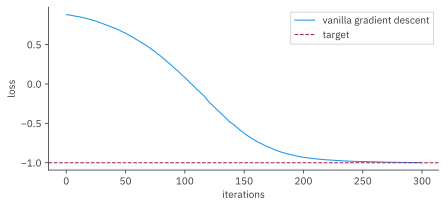

In [13]:
x_opt, fx_opt, nfevs = gd.optimize(
    initial_point.size,    # number of parameters
    evaluate_expectation,  # function to minimize
    gradient_function=evaluate_gradient,  # function to evaluate gradient
    initial_point=initial_point  # initial point
)

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 3))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### Natural gradients

We see in the above example that we are able to find the minimum of the function using gradient descent. However gradient descent is not always the best stratgey.

![Two images, the left one with a circular landscape, and the path of a gradient descent algorithm shown finding the minimum. The landscape on the right is squashed horizontally, and the path of a gradient descent algorithm is shown overshooting the minium a few times.](images/training/gradient-fail.png)

For example, if we look at the diagram on the left, given the initial point on the edge of the [loss landscape](gloss:loss-landscape), $\theta_0 = (x_0,y_0)$ and learning rate $\eta$, we can approach the minimum in the centre. However, looking at the diagram on the right, where the loss landscape has been squashed in the $x$-dimension, we see that using the same initial point and learning rate, we can't find the minimum as we're not taking into account that the loss landscape might vary at a different rate with respect to each parameter. Both models show the same [Euclidean distance](gloss:euclidean-distance) between $(x_0, y_0), (x_1, y_1)$, but this is insufficient for Model B because this metric fails to capture the relative sensitivities. 

The idea of natural gradients is to change the way we determine $\theta_{n+1}$ from $\theta_n$, by considering the sensitivity of the model. In vanilla gradients, we used the Euclidean distance between them: $d = \class{euclidean_distance}{\lVert\vec\theta_{n+1}-\vec\theta_n\rVert_2}$, but we saw that this doesn't take the loss landscape into account. With natural gradients, we instead use a distance that depends on our model: $d = \lVert\langle \Psi(\vec\theta_n) | \Psi(\vec\theta_{n+1}) \rangle \rVert^2$.

![Two images, the left one with a circular landscape, and a line drawn between two points on the landscape. One point is near the edge of the landscape, and the other near the minimum at the centre. The landscape on the right is squashed horizontally, but there is a line drawn between two points on the landscape. One point is near the edge of the landscape, and the other near the minimum at the centre.](images/training/distance.png)

![](images/training/qfi.svg)

This metric is called the _Quantum Fisher Information_, $g_{ij}(\vec\theta)$, and allows us to transform the steepest descent in the Euclidean parameter space to the steepest descent in the model space. This is called the _Quantum Natural Gradient_, and is introduced in Reference 2, where $\vec\theta_{n+1} = \vec\theta_n-\eta \class{}{g^{-1}}(\vec\theta_n)\vec{\nabla} f(\theta_n)$.

![Two images, the left one with a circular landscape, and the path of a gradient descent algorithm shown finding the minimum. The landscape on the right is squashed horizontally, and the path of a gradient descent algorithm is shown, with each step also squashed horizontally, allowing the path to find the minimum.](images/training/natural-gradients.png)

We can evaluate the natural gradient in Qiskit using the [`NaturalGradient`](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.NaturalGradient.html) instead of the [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.opflow.gradients.Gradient.html).

In [14]:
from qiskit.opflow import NaturalGradient

Analogous to the function that computes gradients, we can now write a function that evaluates the natural gradients.

In [15]:
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)    

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.7158704  -0.86457346 -0.98086467 -0.33820315]


And as you can see they do indeed differ!

Let's look at how this influences the convergence.

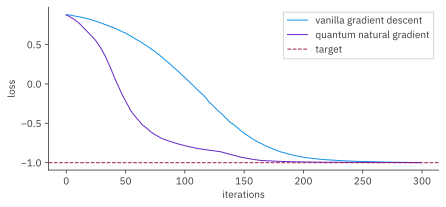

In [16]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)

qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_callback)

x_opt, fx_opt, nfevs = (
    qng.optimize(initial_point.size, 
                 evaluate_expectation, 
                 gradient_function=evaluate_natural_gradient,
                 initial_point=initial_point))

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

This looks great! We can see that the quantum natural gradient approaches the target faster than vanilla gradient descent. However, this comes at the cost of needing to evaluate many many more quantum circuits.

![Graph of '[evaluations](gloss:evaluations) per iteration' on the y-axis and 'number of parameters in anstaz' on x-axis. Two lines are plotted, one labelled "natural gradient" and the other "vanilla gradient", the vanilla gradient line is lower than the natural at all points on the graph and grows at a slower rate.](images/training/gradient-cost-no-spsa.svg)

### Simultaneous Perturbation Stochastic Approximation

Looking at our function $f(\vec\theta)$ as a vector, if we want to evaluate the gradient $\vec{\nabla} f(\vec\theta)$, we need to calculate the partial derivation of $f(\vec\theta)$ with respect to each parameter, meaning we would need $2N$ function evaluations for $N$ parameters to calculate the gradient.

![](images/training/spsa.svg)

Simultaneous [Perturbation](gloss:perturbation) [Stochastic](gloss:stochastic) Approximation (SPSA) is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

In practise, while the exact gradient follows a smooth path to the minimum, SPSA will jump around due to the random sampling, but it will converge, given the same boundary conditions as the gradient. 

And how does it perform? We use the [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) algorithm in Qiskit. 

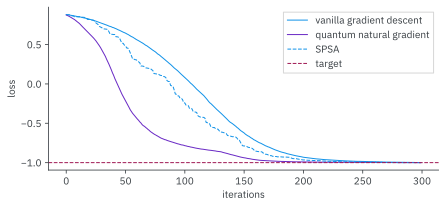

In [17]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

We can see that SPSA basically follows the gradient descent curve, and at a fraction of the cost!

We can do the same for natural gradients as well, as described in Reference 3. We'll skip the details here, but the idea is to sample not only from the gradient, but to extend this to the quantum Fisher information and thus to the natural gradient.

Qiskit implements this as the [`QNSPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html) algorithm. Let's compare its performance:

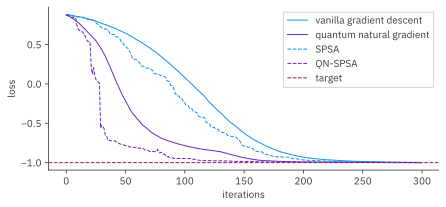

In [18]:
from qiskit.algorithms.optimizers import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

We can see that QNSPSA somewhat follows the natural gradient descent curve. 

![Graph of 'evaluations per iteration' on the y-axis and 'number of parameters in anstaz' on x-axis. Two solid lines are plotted, one labelled "natural gradient" and the other "vanilla gradient", the vanilla gradient line is lower than the natural at all points on the graph and grows at a slower rate. Two dotted horizontal lines are plotted. The higher horizontal line is labelled "QN-SPSA" and intersects the y-axis just above the "natural gradient" line. The lower dotted line is labelled "SPSA" and intersects just above the "vanilla gradient" line](images/training/gradient-costs.svg)

If we compare the costs, we can see that the vanilla and natural gradients are [linear](gloss:linear-and-quadratic) and [quadratic](gloss:linear-and-quadratic) in terms of the number of parameters, while the costs for SPSA and QNSPSA are constant, they are independent of the number of parameters. There is the small offset between the costs for SPSA and QNSPSA as more evaluations are required to approximate the natural gradient. 

<!-- ::: q-block.exercise -->

### Quick quiz

    q-carousel
        q-quiz(goal="qml-training-quizousel-0")
            .question.md The _Gradient_ training method...
            .option(x) updates the circuit parameters using the gradient of the loss function
            .option updates the circuit parameters using the quantum natural gradient of the loss function
            .option updates the circuit parameters using the approximate gradient of the loss function, calculated using ramdom sampling
            .option update the circuit parameters using the approximate quantum natural gradient of the loss function, calculated using ramdom sampling

        q-quiz(goal="qml-training-quizousel-1")
            .question.md The _Natural Gradient_ training method...
            .option updates the circuit parameters using the gradient of the loss function
            .option(x) updates the circuit parameters using the quantum natural gradient of the loss function
            .option updates the circuit parameters using the approximate gradient of the loss function, calculated using ramdom sampling
            .option update the circuit parameters using the approximate quantum natural gradient of the loss function, calculated using ramdom sampling

        q-quiz(goal="qml-training-quizousel-2")
            .question.md The _SPSA_ training method...
            .option updates the circuit parameters using the gradient of the loss function
            .option updates the circuit parameters using the quantum natural gradient of the loss function
            .option(x) updates the circuit parameters using the approximate gradient of the loss function, calculated using ramdom sampling
            .option update the circuit parameters using the approximate quantum natural gradient of the loss function, calculated using ramdom sampling

        q-quiz(goal="qml-training-quizousel-3")
            .question.md The _QNSPSA_ training method...
            .option updates the circuit parameters using the gradient of the loss function
            .option updates the circuit parameters using the quantum natural gradient of the loss function
            .option updates the circuit parameters using the approximate gradient of the loss function, calculated using ramdom sampling
            .option(x) update the circuit parameters using the approximate quantum natural gradient of the loss function, calculated using ramdom sampling

<!-- ::: -->

### Training in practice

In this era of near-term quantum computing, circuit evaluations are expensive, and readouts are not perfect due to the noisy nature of the devices. Therefore in practice, people often resort to using SPSA. To improve convergence, we don't use a constant learning rate, but an exponentially decreasing one. The diagram below shows the typical convergence between a constant learning rate (dotted lines) versus an exponentially decreasing one (solid lines). We see that the convergence for a constant learning rate is smooth decreasing line, while the convergence for an exponentially decreasing one is steeper and more staggered. This works well if you know what your loss function looks like. 

![Graph with "Loss" on the y-xis and "Iterations" on the x-axis. There is a green horizontal line labelled "target" towards the bottom of the graph. A dotted curve labelled "fixed eta" starts high on the y-axis and tends slowly down towards the target line. A different, noisy curve labelled "powerlaw eta" starts at the same point on the y-axis as "fixed eta", but descends faster towards the "Target line".](images/training/learning-rate-0.svg)

![Graph with "Learning rate (eta)" on the y-xis and "Iterations" on the x-axis. There is a green, dotted, horizontal line labelled "eta = const" roughly 30% up the y-axis. A dotted curve labelled "eta proportional to alpha^n" starts high on the y-axis and tends slowly down past the "eta = const" line..](images/training/learning-rate-1.svg)

Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

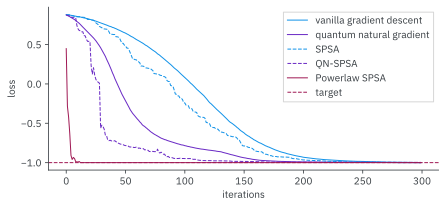

In [19]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_loss, 'C3', label='Powerlaw SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

We see here that it works the best of all the methods for this small model. For larger models, the convergence will probably be more like the natural gradient. 

## Limitations

We've seen that training with gradients works well on the small example model. But can we expect the same if we increase the number of qubits? To investigate that, we measure the [variance](gloss:variance) of the gradients for different model sizes. The idea is simple: if the variance is really small, we don't have enough information to update our parameters.

### Exponentially vanishing gradients (barren plateaus)

Let's pick a standard parameterized quantum circuit ([`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)) and see what happens if we increase the number of qubits and layers, that is increase the width and depth of thee circuit) as we calculate the gradient.

![Image of an 'n' qubit quantum cirucit. An RY(theta_n) acts on each qubit, followed by some CNOTs and more RY gates (with different parameters). The CNOTs and other RY gates are repeated 'n' times.](images/training/bpcircuit.svg)

In [20]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads

Let's plot from 2 to 12 qubits.

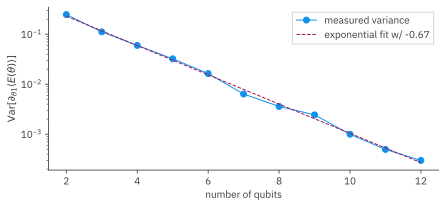

In [21]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

Oh no! The variance decreases exponentially! This means our gradients contain less and less information and we'll have a hard time to train the model. This is known as the "[barren plateau](gloss:barren-plateau) problem", or "exponentially vanishing gradients", discussed in detail in References 4 and 5. 

<!-- ::: q-block.exercise -->

### Try it

Do natural gradients have barren plateaus? Try create the above barren plateau plot for natural gradients instead of vanilla gradients in [IBM Quantum Lab](https://quantum-computing.ibm.com/lab). You will need to write a new function `sample_natural_gradients` that computes the natural gradient instead of the gradient.

<!-- ::: -->

Is there something we can do about these barren plateaus? It's a hot topic in current research and there are some proposals to mitigate barren plateaus.

Let's have a look at how global and local cost functions and the depth of the ansatz influences the barren plateaus. First, we'll look at short depth, single layer circuits with [global operators](gloss:global-operator). 

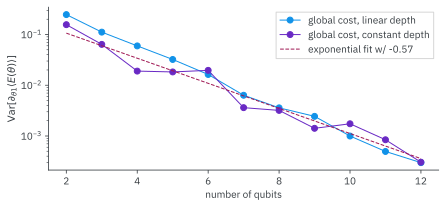

In [22]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

We see that short depth, single layer circuits with global operators still give us barren plateaus. 

What if we use local operators?

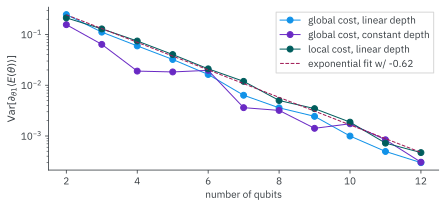

In [23]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n,
                                            local=True) for n in num_qubits]  

fit = np.polyfit(num_qubits,
                 np.log(np.var(linear_depth_local_gradients,axis=1)),
                 deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-',
             label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-',
             label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that circuits with local operators still give us barren plateaus. 

How about short depth, single layer, circuits with local operators?

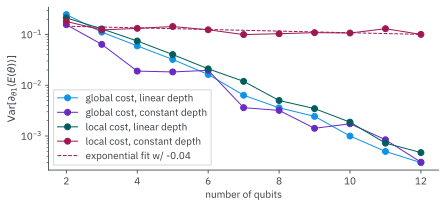

In [24]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1,
                                            local=True) for n in num_qubits]  

fit = np.polyfit(num_qubits,
                 np.log(np.var(fixed_depth_local_gradients, axis=1)),
                 deg=1)

x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-',
             label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-',
             label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', 
             label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3', 
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

We see that the variance of the local operator, constant depth circuit gradients don't vanish, that is, we don't get barren plateaus. However, these circuits are usually easy to simulate and hence these models won't provide any advantage over classical models.

<!-- ::: q-block.exercise -->

### Quick quiz

<!-- ::: q-quiz(goal="qml-training-1") -->

<!-- ::: .question -->

The variance of the gradient does not vanish for which types of circuit?

<!-- ::: -->

<!-- ::: .option -->

1. global operator, linear depth

<!-- ::: -->

<!-- ::: .option -->

2. global operator, constant depth

<!-- ::: -->

<!-- ::: .option -->

3. local operator, linear depth

<!-- ::: -->

<!-- ::: .option(correct) -->

3. local operator, constant depth

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

This is the inspiration for layerwise training, where we start with a basic circuit that may not provide any quantum advantage, with one layer of rotations using local operators. We optimize and fix these parameters, then in the next step, we aad a second layer of rotations using local operators, and optimize and fix those, and continue for however many layers we want. This potentially avoids barren plateaus as each optimization step is only using constant depth circuits with local operators. 

![There are three, 3-qubit quantum circuits, one of each of three iterations. In the first circuit, there is only one layer of parameterised gates, which we train in iteration 1. Each following iteration gradually adds more parameterised gates and trains only these new gates.](images/training/layertraining.svg)

We can implement this in Qiskit in the following way:

In [25]:
num_qubits = 6
operator = Z ^ Z ^ (I ^ (num_qubits - 4))

def minimize(circuit, optimizer):
    initial_point = np.random.random(circuit.num_parameters)
    
    exp = StateFn(operator, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)
    
    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")
    
    def loss(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(exp, values_dict).eval())
    
    def gradient(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.optimize(circuit.num_parameters,
                              loss, gradient,
                              initial_point=initial_point)

def layerwise_training(ansatz, max_num_layers, optimizer):
    optimal_parameters = []
    fopt = None
    for reps in range(1, max_num_layers):
        ansatz.reps = reps
     
        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))

        # mark parameters that need to be optimized
        partially_bound = ansatz.bind_parameters(values_dict)

        xopt, fopt, _ = minimize(partially_bound, optimizer)
        print('Layer:', reps, ' Best Value:', fopt)
        optimal_parameters += list(xopt)

    return fopt, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Layer: 1  Best Value: 0.2421875
Layer: 2  Best Value: -0.14428710937499992
Layer: 3  Best Value: -0.513427734375


We see that as we increase the circuit depth, our loss function decreases towards -1, so we don't see any barren plateaus. 

## References

1. Maria Schuld, Ville Bergholm, Christian Gogolin, Josh Izaac and Nathan Killoran, *Evaluating analytic gradients on quantum hardware*, Physical Revview A 99, 032331 (2019), [doi:10.1103/PhysRevA.99.032331](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331), [arXiv:1811.11184](https://arxiv.org/abs/1811.11184).
2. James Stokes, Josh Izaac, Nathan Killoran and Giuseppe Carleo, *Quantum Natural Gradient*, Quantum 4, 269 (2020), [doi:10.22331/q-2020-05-25-269](https://doi.org/10.22331/q-2020-05-25-269), [arXiv:1909.02108](https://arxiv.org/abs/1909.02108).
3. Julien Gacon, Christa Zoufal, Giuseppe Carleo and Stefan Woerner, *Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information*, [arXiv:2103.09232](https://arxiv.org/abs/2103.09232).
4. Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, *Barren plateaus in quantum neural network training landscapes*, Nature Communications, Volume 9, 4812 (2018), [doi:10.1038/s41467-018-07090-4](https://www.nature.com/articles/s41467-018-07090-4), [arXiv:1803.11173](https://arxiv.org/abs/1803.11173).
5. M. Cerezo, Akira Sone, Tyler Volkoff, Lukasz Cincio and Patrick J. Coles, *Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits*, Nature Communications 12, 1791 (2021), [doi:10.1038/s41467-021-21728-w](https://www.nature.com/articles/s41467-021-21728-w), [arXiv:2001.00550](https://arxiv.org/abs/2001.00550).

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table